In [385]:
import sqlite3
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    roc_auc_score,
    brier_score_loss,
)
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
np.random.seed(42)

In [386]:
DB_PATH = "nhl_scrape.sqlite"

# Explicitly list seasons to include
TABLES = [
    "games_table_20152016",
    "games_table_20162017",
    "games_table_20172018",
    "games_table_20182019",
    "games_table_20192020",
    # "games_table_20202021",  # ❌ OMIT (COVID)
    "games_table_20212022",
    "games_table_20222023",
    "games_table_20232024",
    "games_table_20242025",
]

conn = sqlite3.connect(DB_PATH)

dfs = []
for t in TABLES:
    print(f"Loading {t}")
    df_t = pd.read_sql(f"SELECT * FROM {t}", conn)
    df_t["season_table"] = t  # optional but useful for debugging
    dfs.append(df_t)

conn.close()

df = pd.concat(dfs, axis=0, ignore_index=True)

df.to_csv('test.csv')

# final sort (critical)
df = df.sort_values(["gameDate", "gamePk"]).reset_index(drop=True)

print(df.shape)
df.head()


Loading games_table_20152016
Loading games_table_20162017
Loading games_table_20172018
Loading games_table_20182019
Loading games_table_20192020
Loading games_table_20212022
Loading games_table_20222023
Loading games_table_20232024
Loading games_table_20242025
(9853, 191)


,gamePk,season,gameDate,homeTeamAbbrev_x,awayTeamAbbrev_x,homeTeamName,awayTeamName,homeWin,homeTeamAbbrev_y,home_season_GF_mean,home_season_GF_std,home_season_GA_mean,home_season_GA_std,home_season_SOGF_mean,home_season_SOGF_std,home_season_SOGA_mean,home_season_SOGA_std,home_season_SHOTDIFF_mean,home_season_SHOTDIFF_std,home_season_PPOPP_mean,home_season_PPOPP_std,home_season_PPPCT_mean,home_season_PPPCT_std,home_season_PKPCT_mean,home_season_PKPCT_std,home_season_STI_mean,home_season_STI_std,home_season_FO_PCT_mean,home_season_FO_PCT_std,home_season_HITS_mean,home_season_HITS_std,home_season_BLKS_mean,home_season_BLKS_std,home_season_PIM_mean,home_season_PIM_std,home_season_GIVE_mean,home_season_GIVE_std,home_season_TAKE_mean,home_season_TAKE_std,home_season_SHPCT_mean,home_season_SHPCT_std,home_season_SVPCT_mean,home_season_SVPCT_std,home_season_PDO_mean,home_season_PDO_std,home_last5_GF_mean,home_last5_GF_std,home_last5_GA_mean,home_last5_GA_std,home_last5_SOGF_mean,home_last5_SOGF_std,home_last5_SOGA_mean,home_last5_SOGA_std,home_last5_SHOTDIFF_mean,home_last5_SHOTDIFF_std,home_last5_PPOPP_mean,home_last5_PPOPP_std,home_last5_PPPCT_mean,home_last5_PPPCT_std,home_last5_PKPCT_mean,home_last5_PKPCT_std,home_last5_STI_mean,home_last5_STI_std,home_last5_FO_PCT_mean,home_last5_FO_PCT_std,home_last5_HITS_mean,home_last5_HITS_std,home_last5_BLKS_mean,home_last5_BLKS_std,home_last5_PIM_mean,home_last5_PIM_std,home_last5_GIVE_mean,home_last5_GIVE_std,home_last5_TAKE_mean,home_last5_TAKE_std,home_last5_SHPCT_mean,home_last5_SHPCT_std,home_last5_SVPCT_mean,home_last5_SVPCT_std,home_last5_PDO_mean,home_last5_PDO_std,home_season_GF_rank,home_season_GA_rank,home_season_SOGF_rank,home_season_SOGA_rank,home_season_SHOTDIFF_rank,home_season_PPOPP_rank,home_season_PPPCT_rank,home_season_PKPCT_rank,home_season_STI_rank,home_season_FO_PCT_rank,home_season_HITS_rank,home_season_BLKS_rank,home_season_PIM_rank,home_season_GIVE_rank,home_season_TAKE_rank,home_season_SHPCT_rank,home_season_SVPCT_rank,home_season_PDO_rank,awayTeamAbbrev_y,away_season_GF_mean,away_season_GF_std,away_season_GA_mean,away_season_GA_std,away_season_SOGF_mean,away_season_SOGF_std,away_season_SOGA_mean,away_season_SOGA_std,away_season_SHOTDIFF_mean,away_season_SHOTDIFF_std,away_season_PPOPP_mean,away_season_PPOPP_std,away_season_PPPCT_mean,away_season_PPPCT_std,away_season_PKPCT_mean,away_season_PKPCT_std,away_season_STI_mean,away_season_STI_std,away_season_FO_PCT_mean,away_season_FO_PCT_std,away_season_HITS_mean,away_season_HITS_std,away_season_BLKS_mean,away_season_BLKS_std,away_season_PIM_mean,away_season_PIM_std,away_season_GIVE_mean,away_season_GIVE_std,away_season_TAKE_mean,away_season_TAKE_std,away_season_SHPCT_mean,away_season_SHPCT_std,away_season_SVPCT_mean,away_season_SVPCT_std,away_season_PDO_mean,away_season_PDO_std,away_last5_GF_mean,away_last5_GF_std,away_last5_GA_mean,away_last5_GA_std,away_last5_SOGF_mean,away_last5_SOGF_std,away_last5_SOGA_mean,away_last5_SOGA_std,away_last5_SHOTDIFF_mean,away_last5_SHOTDIFF_std,away_last5_PPOPP_mean,away_last5_PPOPP_std,away_last5_PPPCT_mean,away_last5_PPPCT_std,away_last5_PKPCT_mean,away_last5_PKPCT_std,away_last5_STI_mean,away_last5_STI_std,away_last5_FO_PCT_mean,away_last5_FO_PCT_std,away_last5_HITS_mean,away_last5_HITS_std,away_last5_BLKS_mean,away_last5_BLKS_std,away_last5_PIM_mean,away_last5_PIM_std,away_last5_GIVE_mean,away_last5_GIVE_std,away_last5_TAKE_mean,away_last5_TAKE_std,away_last5_SHPCT_mean,away_last5_SHPCT_std,away_last5_SVPCT_mean,away_last5_SVPCT_std,away_last5_PDO_mean,away_last5_PDO_std,away_season_GF_rank,away_season_GA_rank,away_season_SOGF_rank,away_season_SOGA_rank,away_season_SHOTDIFF_rank,away_season_PPOPP_rank,away_season_PPPCT_rank,away_season_PKPCT_rank,away_season_STI_rank,away_season_FO_PCT_rank,away_season_HITS_rank,away_season_BLKS_rank,away_season_PIM_rank,away_season_GIVE_rank,away_season_TAKE_rank,away_season_SHPCT_rank,away_season_SVPCT_rank,away_season_PDO_rank,season_table
0,201

In [387]:
TARGET = "homeWin"

# drop rows with missing target
df = df.dropna(subset=[TARGET]).copy()

# sort chronologically (critical)
df = df.sort_values(["gameDate", "gamePk"]).reset_index(drop=True)

print(df[TARGET].mean())

0.5417639297675835


In [388]:
def make_diff_features(df):
    diff_cols = []
    for c in df.columns:
        if c.startswith("home_") and c.replace("home_", "away_") in df.columns:
            diff_name = c.replace("home_", "diff_")
            df[diff_name] = df[c] - df[c.replace("home_", "away_")]
            diff_cols.append(diff_name)
    return df, diff_cols

df, DIFF_COLS = make_diff_features(df)
len(DIFF_COLS)

90

In [389]:
DROP_COLS = [
    TARGET,
    "gamePk",
    "gameDate",
]

X = df[DIFF_COLS].replace([np.inf, -np.inf], np.nan)
y = df[TARGET].astype(int)

# drop columns that are mostly missing
valid_cols = X.columns[X.isna().mean() < 0.30]
X = X[valid_cols]

print(X.shape)

(9853, 90)


In [390]:
def drop_high_corr(X, thresh=0.95):
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop = [c for c in upper.columns if any(upper[c] > thresh)]
    return X.drop(columns=drop), drop

X_corr, dropped_corr = drop_high_corr(X, thresh=0.95)
print(f"Dropped {len(dropped_corr)} correlated features")

Dropped 0 correlated features


In [391]:
TRAIN_START_DATE = "2015-11-11"   # applies to all seasons

mask_after_nov11 = df["gameDate"] >= TRAIN_START_DATE

df_filt = df.loc[mask_after_nov11].copy()

print("Original rows:", len(df))
print("After Nov 11 cutoff:", len(df_filt))

X_filt = X_corr.loc[df_filt.index]
y_filt = y.loc[df_filt.index]

Original rows: 9853
After Nov 11 cutoff: 9789


In [ ]:
split_date = "2023-10-01"

train_idx = df["gameDate"] < split_date
test_idx  = df["gameDate"] >= split_date

X_train, X_test = X_corr.loc[train_idx], X_corr.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

print(X_train.shape, X_test.shape)


(7555, 90) (2298, 90)


,diff_season_GF_mean,diff_season_GF_std,diff_season_GA_mean,diff_season_GA_std,diff_season_SOGF_mean,diff_season_SOGF_std,diff_season_SOGA_mean,diff_season_SOGA_std,diff_season_SHOTDIFF_mean,diff_season_SHOTDIFF_std,diff_season_PPOPP_mean,diff_season_PPOPP_std,diff_season_PPPCT_mean,diff_season_PPPCT_std,diff_season_PKPCT_mean,diff_season_PKPCT_std,diff_season_STI_mean,diff_season_STI_std,diff_season_FO_PCT_mean,diff_season_FO_PCT_std,diff_season_HITS_mean,diff_season_HITS_std,diff_season_BLKS_mean,diff_season_BLKS_std,diff_season_PIM_mean,diff_season_PIM_std,diff_season_GIVE_mean,diff_season_GIVE_std,diff_season_TAKE_mean,diff_season_TAKE_std,diff_season_SHPCT_mean,diff_season_SHPCT_std,diff_season_SVPCT_mean,diff_season_SVPCT_std,diff_season_PDO_mean,diff_season_PDO_std,diff_last5_GF_mean,diff_last5_GF_std,diff_last5_GA_mean,diff_last5_GA_std,diff_last5_SOGF_mean,diff_last5_SOGF_std,diff_last5_SOGA_mean,diff_last5_SOGA_std,diff_last5_SHOTDIFF_mean,diff_last5_SHOTDIFF_std,diff_last5_PPOPP_mean,diff_last5_PPOPP_std,diff_last5_PPPCT_mean,diff_last5_PPPCT_std,diff_last5_PKPCT_mean,diff_last5_PKPCT_std,diff_last5_STI_mean,diff_last5_STI_std,diff_last5_FO_PCT_mean,diff_last5_FO_PCT_std,diff_last5_HITS_mean,diff_last5_HITS_std,diff_last5_BLKS_mean,diff_last5_BLKS_std,diff_last5_PIM_mean,diff_last5_PIM_std,diff_last5_GIVE_mean,diff_last5_GIVE_std,diff_last5_TAKE_mean,diff_last5_TAKE_std,diff_last5_SHPCT_mean,diff_last5_SHPCT_std,diff_last5_SVPCT_mean,diff_last5_SVPCT_std,diff_last5_PDO_mean,diff_last5_PDO_std,diff_season_GF_rank,diff_season_GA_rank,diff_season_SOGF_rank,diff_season_SOGA_rank,diff_season_SHOTDIFF_rank,diff_season_PPOPP_rank,diff_season_PPPCT_rank,diff_season_PKPCT_rank,diff_season_STI_rank,diff_season_FO_PCT_rank,diff_season_HITS_rank,diff_season_BLKS_rank,diff_season_PIM_rank,diff_season_GIVE_rank,diff_season_TAKE_rank,diff_season_SHPCT_rank,diff_season_SVPCT_rank,diff_season_PDO_rank
7555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [393]:
logit = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=2000
    ))
])


ann = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        alpha=1e-3,
        max_iter=500,
        random_state=42
    ))
])

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=8,
        min_samples_leaf=25,
        random_state=42,
        n_jobs=-1
    ))
])


xgb_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", xgb.XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])


lgb_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", lgb.LGBMClassifier(
        n_estimators=600,
        max_depth=-1,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])



In [394]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name):
    model.fit(X_tr, y_tr)

    p_tr = model.predict_proba(X_tr)[:, 1]
    p_te = model.predict_proba(X_te)[:, 1]

    out = {
        "model": name,
        "train_logloss": log_loss(y_tr, p_tr),
        "test_logloss": log_loss(y_te, p_te),
        "train_auc": roc_auc_score(y_tr, p_tr),
        "test_auc": roc_auc_score(y_te, p_te),
        "test_brier": brier_score_loss(y_te, p_te),
        "test_acc": accuracy_score(y_te, (p_te > 0.5))
    }
    return out, p_te


In [395]:
results = []
preds = {}

for name, model in [
    ("Logit", logit),
    # ("ANN", ann),
    ("RandomForest", rf),
    # ("XGBoost", xgb_model),
    # ("LightGBM", lgb_model),
]:
    res, p = evaluate(model, X_train, y_train, X_test, y_test, name)
    results.append(res)
    preds[name] = p

pd.DataFrame(results).sort_values("test_logloss")


,model,train_logloss,test_logloss,train_auc,test_auc,test_brier,test_acc
1,RandomForest,0.608399,0.668298,0.801768,0.611687,0.237880,0.589643
0,Logit,0.667794,0.670470,0.621929,0.610086,0.238989,0.581375


/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


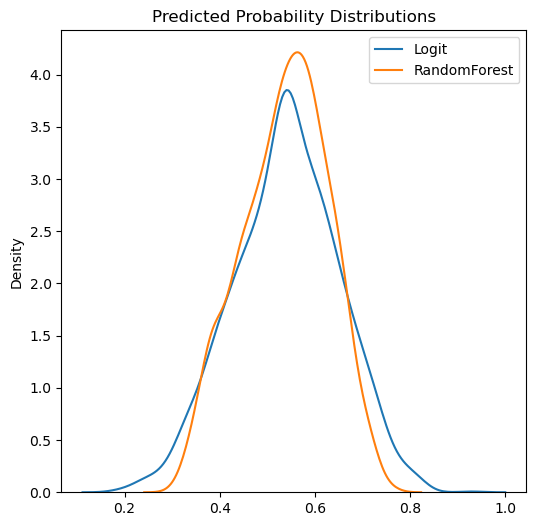

In [396]:
plt.figure(figsize=(6,6))
for k, p in preds.items():
    sns.kdeplot(p, label=k)
plt.legend()
plt.title("Predicted Probability Distributions")
plt.show()


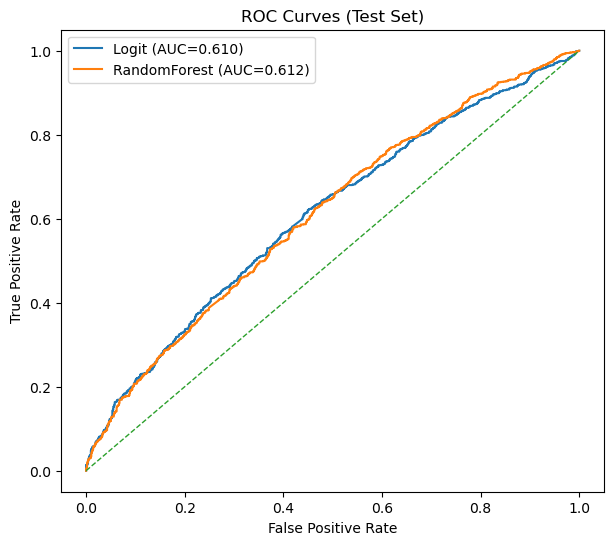

In [397]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7, 6))
for name, p in preds.items():
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()


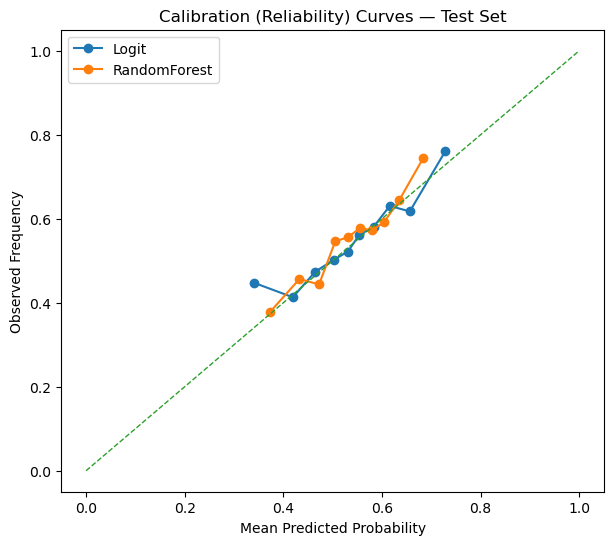

In [398]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(7, 6))
for name, p in preds.items():
    frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=name)

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration (Reliability) Curves — Test Set")
plt.legend()
plt.show()


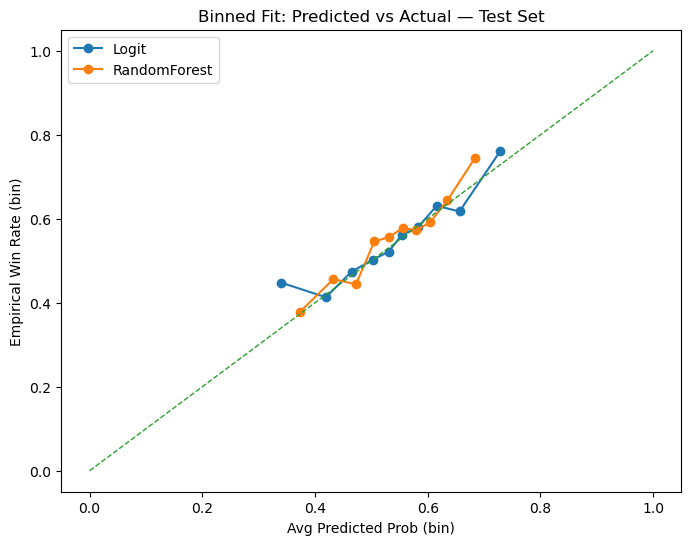

Showing bin table for: RandomForest


,n,p_mean,y_mean,p_min,p_max
0,230,0.373317,0.378261,0.299019,0.406834
1,230,0.432744,0.456522,0.406984,0.452974
2,230,0.472413,0.443478,0.453197,0.489002
3,229,0.505208,0.545852,0.489132,0.518261
4,230,0.531748,0.556522,0.518298,0.544033
5,230,0.555851,0.578261,0.544229,0.567337
6,229,0.579167,0.572052,0.567440,0.591065
7,230,0.603915,0.591304,0.591144,0.618146
8,230,0.634633,0.643478,0.618188,0.652135
9,230,0.683260,0.743478,0.652220,0.765661


In [399]:
def binned_fit(y_true, p, n_bins=10):
    df_tmp = pd.DataFrame({"y": y_true.values, "p": p})
    df_tmp["bin"] = pd.qcut(df_tmp["p"], q=n_bins, duplicates="drop")
    g = df_tmp.groupby("bin", observed=True).agg(
        n=("y", "size"),
        p_mean=("p", "mean"),
        y_mean=("y", "mean"),
        p_min=("p", "min"),
        p_max=("p", "max"),
    ).reset_index(drop=True)
    return g

plt.figure(figsize=(8, 6))
for name, p in preds.items():
    g = binned_fit(y_test, p, n_bins=10)
    plt.plot(g["p_mean"], g["y_mean"], marker="o", label=name)

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("Avg Predicted Prob (bin)")
plt.ylabel("Empirical Win Rate (bin)")
plt.title("Binned Fit: Predicted vs Actual — Test Set")
plt.legend()
plt.show()

# Optional: show the table for the best model (change name as desired)
best_name = min(results, key=lambda r: r["test_logloss"])["model"]
print("Showing bin table for:", best_name)
display(binned_fit(y_test, preds[best_name], n_bins=10))


In [400]:
import numpy as np
import pandas as pd

MODEL_NAME = "Logit"  # or "Logit"

def american_to_decimal(amer):
    """American odds -> decimal odds."""
    if pd.isna(amer):
        return np.nan
    amer = float(amer)
    if amer > 0:
        return 1.0 + (amer / 100.0)
    else:
        return 1.0 + (100.0 / abs(amer))

def implied_prob_from_american(amer):
    """Implied prob from American odds (no vig removal)."""
    if pd.isna(amer):
        return np.nan
    amer = float(amer)
    if amer > 0:
        return 100.0 / (amer + 100.0)
    else:
        return abs(amer) / (abs(amer) + 100.0)

def kelly_fraction(p, dec_odds):
    """
    Kelly fraction for a 1-unit stake with decimal odds.
    b = dec_odds - 1
    f* = (b*p - (1-p)) / b
    """
    if pd.isna(p) or pd.isna(dec_odds):
        return 0.0
    b = dec_odds - 1.0
    if b <= 0:
        return 0.0
    f = (b * p - (1.0 - p)) / b
    return max(0.0, f)

def max_drawdown(equity):
    """equity: array-like of bankroll over time"""
    eq = np.asarray(equity, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = (eq - peak) / peak
    return dd.min()  # negative number

def summarize_backtest(df_bets, equity_curve, starting_bankroll):
    n = len(df_bets)
    if n == 0:
        return {
            "n_bets": 0,
            "roi": 0.0,
            "profit": 0.0,
            "ending_bankroll": starting_bankroll,
            "max_drawdown": 0.0,
            "hit_rate": np.nan,
            "avg_edge": np.nan,
            "avg_stake": np.nan,
        }

    profit = equity_curve[-1] - starting_bankroll
    roi = profit / starting_bankroll
    hit_rate = (df_bets["pnl"] > 0).mean()
    return {
        "n_bets": int(n),
        "roi": float(roi),
        "profit": float(profit),
        "ending_bankroll": float(equity_curve[-1]),
        "max_drawdown": float(max_drawdown(equity_curve)),
        "hit_rate": float(hit_rate),
        "avg_edge": float(df_bets["edge"].mean()),
        "avg_stake": float(df_bets["stake"].mean()),
    }


In [401]:
ODDS_CSV = "nhl_odds_2023_2024_closing.csv"  # adjust path if needed
odds = pd.read_csv(ODDS_CSV)

# Try to find key columns
cols = {c.lower(): c for c in odds.columns}

def need(*names):
    for n in names:
        if n.lower() in cols:
            return cols[n.lower()]
    return None

c_game = need("game_id", "gamepk", "gamePk")
c_home = need("home_odds", "homeOdds", "home_ml", "home_moneyline")
c_away = need("away_odds", "awayOdds", "away_ml", "away_moneyline")
c_date = need("date", "game_date", "gameDate")

print("Detected columns:")
print(" game:", c_game)
print(" home:", c_home)
print(" away:", c_away)
print(" date:", c_date)

if c_game is None or c_home is None or c_away is None:
    raise ValueError(f"Odds CSV missing required columns. Found: {list(odds.columns)}")

odds_small = odds[[c_game, c_home, c_away] + ([c_date] if c_date else [])].copy()
odds_small = odds_small.rename(columns={c_game: "gamePk", c_home: "home_odds", c_away: "away_odds"})
if c_date:
    odds_small = odds_small.rename(columns={c_date: "date"})
else:
    odds_small["date"] = np.nan

# Ensure gamePk string for safe merging
odds_small["gamePk"] = odds_small["gamePk"].astype(str)

print("Odds rows:", len(odds_small))
odds_small.head()


Detected columns:
 game: game_id
 home: home_odds
 away: away_odds
 date: date
Odds rows: 2214


,gamePk,home_odds,away_odds,date
0,2023020141,-110.0,-110.0,2023-11-01
1,2023020142,118.0,-142.0,2023-11-01
2,2023020143,-240.0,195.0,2023-11-01
3,2023020144,108.0,-130.0,2023-11-01
4,2023020147,104.0,-125.0,2023-11-02


In [402]:
# --- Force backtest universe to match the odds CSV coverage ---
odds_small = odds_small.copy()
odds_small["gamePk"] = odds_small["gamePk"].astype(str)

# Only keep test rows that actually have odds (prevents silent universe drift)
odds_game_ids = set(odds_small["gamePk"].unique())

df_test = df.loc[test_idx, ["gamePk", "gameDate", "homeWin"]].copy()
df_test["gamePk"] = df_test["gamePk"].astype(str)

df_test = df_test[df_test["gamePk"].isin(odds_game_ids)].copy()

# Align probs to filtered df_test
# (If your preds are a numpy array aligned to X_test, filter it the same way.)
mask = X_test.index.isin(df_test.index)
p_home = preds[MODEL_NAME][mask]

assert len(df_test) == len(p_home), (len(df_test), len(p_home))


# Build df_test to align with X_test / y_test
df_test = df.loc[test_idx, ["gamePk", "gameDate", "homeWin"]].copy()

# Safety checks
assert len(df_test) == len(X_test)
assert df_test.index.equals(X_test.index)

df_test.head()

# df_test must include gamePk + homeWin + gameDate (or date)
# Adjust these if your column names differ
df_bt = df_test[["gamePk", "gameDate", "homeWin"]].copy()
df_bt["gamePk"] = df_bt["gamePk"].astype(str)
# df_test is aligned to X_test / y_test by index
df_test = df.loc[test_idx, ["gamePk", "gameDate", "homeWin"]].copy()

# Build a Series of probabilities indexed like X_test
p_home_s = pd.Series(preds[MODEL_NAME], index=X_test.index, name="p_home")

# If you've filtered df_test at all, keep only indices we have preds for
df_test = df_test.loc[df_test.index.intersection(p_home_s.index)].copy()

df_bt = df_test[["gamePk", "gameDate", "homeWin"]].copy()
df_bt["gamePk"] = df_bt["gamePk"].astype(str)

# Join by index so lengths always match
df_bt = df_bt.join(p_home_s, how="left")

# Safety
assert df_bt["p_home"].notna().all(), "Some df_bt rows have no prediction (index mismatch)."

df_bt["p_away"] = 1.0 - df_bt["p_home"]

# Merge odds onto test games
df_bt = df_bt.merge(odds_small, on="gamePk", how="inner")

# Convert odds -> decimal + implied
df_bt["home_dec"] = df_bt["home_odds"].map(american_to_decimal)
df_bt["away_dec"] = df_bt["away_odds"].map(american_to_decimal)

df_bt["home_imp"] = df_bt["home_odds"].map(implied_prob_from_american)
df_bt["away_imp"] = df_bt["away_odds"].map(implied_prob_from_american)

df_bt["edge_home"] = df_bt["p_home"] - df_bt["home_imp"]
df_bt["edge_away"] = df_bt["p_away"] - df_bt["away_imp"]

print("Backtest games after merge:", len(df_bt))
print("Date range:", df_bt["gameDate"].min(), "->", df_bt["gameDate"].max())
print("Implied overround (mean):", (df_bt["home_imp"] + df_bt["away_imp"]).mean())

df_bt.head()


Backtest games after merge: 2214
Date range: 2023-11-01 00:00:00 -> 2025-04-15 00:00:00
Implied overround (mean): 1.0474052319259648


,gamePk,gameDate,homeWin,p_home,p_away,home_odds,away_odds,date,home_dec,away_dec,home_imp,away_imp,edge_home,edge_away
0,2023020141,2023-11-01 00:00:00,0.0,0.538951,0.461049,-110.0,-110.0,2023-11-01,1.909091,1.909091,0.523810,0.523810,0.015142,-0.062761
1,2023020142,2023-11-01 00:00:00,0.0,0.538951,0.461049,118.0,-142.0,2023-11-01,2.180000,1.704225,0.458716,0.586777,0.080236,-0.125728
2,2023020143,2023-11-01 00:00:00,1.0,0.538951,0.461049,-240.0,195.0,2023-11-01,1.416667,2.950000,0.705882,0.338983,-0.166931,0.122066
3,2023020144,2023-11-01 00:00:00,1.0,0.538951,0.461049,108.0,-130.0,2023-11-01,2.080000,1.769231,0.480769,0.565217,0.058182,-0.104169
4,2023020145,2023-11-02 00:00:00,1.0,0.538951,0.461049,-104.0,-115.0,2023-11-02,1.961538,1.869565,0.509804,0.534884,0.029147,-0.073835


In [403]:
START_BANKROLL = 5000.0
# For closing odds: freeze at 1/10 Kelly
KELLY_SCALE = 0.1          # 1/10 Kelly
# For closing odds: freeze at 3%
MIN_EDGE = 0.02        
# For closing odds: freeze at 5% 
MAX_EDGE = 0.08           
# For closing odds: freeze at 1.5%
MAX_STAKE_FRAC = 0.02      # cap stake fraction per bet

# NEW: exclude this edge band (3%–5%)
EXCL_EDGE_LO = 0.03
EXCL_EDGE_HI = 0.05

# Expected value per $1 stake:
# EV = p * dec_odds - 1
df_bt["ev_home"] = df_bt["p_home"] * df_bt["home_dec"] - 1.0
df_bt["ev_away"] = df_bt["p_away"] * df_bt["away_dec"] - 1.0

# Pick the better side per game
df_bt["side"] = np.where(df_bt["ev_home"] >= df_bt["ev_away"], "home", "away")
df_bt["ev"] = np.where(df_bt["side"] == "home", df_bt["ev_home"], df_bt["ev_away"])

# "Edge" vs implied: p - implied_p (this is the edge you actually bet on)
df_bt["edge_home"] = df_bt["p_home"] - df_bt["home_imp"]
df_bt["edge_away"] = df_bt["p_away"] - df_bt["away_imp"]

df_bt["edge"] = np.where(df_bt["side"] == "home", df_bt["edge_home"], df_bt["edge_away"])
df_bt["p"]    = np.where(df_bt["side"] == "home", df_bt["p_home"], df_bt["p_away"])
df_bt["dec"]  = np.where(df_bt["side"] == "home", df_bt["home_dec"], df_bt["away_dec"])

# NEW: flag the excluded bin
df_bt["edge_excluded"] = (df_bt["edge"] >= EXCL_EDGE_LO) & (df_bt["edge"] < EXCL_EDGE_HI)

# Only bet when:
# - EV is finite
# - edge is within [MIN_EDGE, MAX_EDGE]
# - edge is NOT in excluded band
df_bt["bet"] = (
    np.isfinite(df_bt["ev"]) &
    (df_bt["edge"] >= MIN_EDGE) &
    (df_bt["edge"] <= MAX_EDGE) &
    (~df_bt["edge_excluded"])
)

# Optional market-odds band filter (apply BEFORE staking is fine)
df_bt = df_bt[
    (df_bt["home_dec"] >= 1.6) &
    (df_bt["home_dec"] <= 2.3)
].copy()

# Log-odds gap filter (apply BEFORE staking)
logit_market = np.log(df_bt["home_imp"] / (1 - df_bt["home_imp"]))
logit_model  = np.log(df_bt["p_home"]   / (1 - df_bt["p_home"]))
df_bt["logodds_gap"] = logit_model - logit_market

df_bt = df_bt[df_bt["logodds_gap"].abs() > 0.15].copy()

# Kelly sizing (only for bets)
df_bt["kelly_f"] = df_bt.apply(lambda r: kelly_fraction(r["p"], r["dec"]), axis=1)
df_bt["stake_frac"] = np.minimum(MAX_STAKE_FRAC, KELLY_SCALE * df_bt["kelly_f"])
df_bt.loc[~df_bt["bet"], "stake_frac"] = 0.0

# Simulate bankroll chronologically
df_bt = df_bt.sort_values("gameDate").reset_index(drop=True)

bankroll = START_BANKROLL
equity = [bankroll]
bet_rows = []

for r in df_bt.itertuples(index=False):
    stake = bankroll * float(r.stake_frac)
    if stake <= 0:
        equity.append(bankroll)
        continue

    home_won = int(r.homeWin) == 1
    win = home_won if r.side == "home" else (not home_won)

    pnl = stake * (float(r.dec) - 1.0) if win else -stake
    bankroll += pnl
    equity.append(bankroll)

    bet_rows.append({
        "gamePk": r.gamePk,
        "gameDate": r.gameDate,
        "side": r.side,
        "p": float(r.p),
        "dec": float(r.dec),
        "edge": float(r.edge),
        "stake": float(stake),
        "pnl": float(pnl),
        "bankroll": float(bankroll),
    })

df_bets = pd.DataFrame(bet_rows)
summary = summarize_backtest(df_bets, equity, START_BANKROLL)

print("Excluded bin count (eligible rows):", int(df_bt["edge_excluded"].sum()))
summary



Excluded bin count (eligible rows): 118


{'n_bets': 204,
 'roi': 0.04776632423726132,
 'profit': 238.83162118630662,
 'ending_bankroll': 5238.831621186307,
 'max_drawdown': -0.12113836793097421,
 'hit_rate': 0.5098039215686274,
 'avg_edge': 0.05792650648753875,
 'avg_stake': 59.3960596605365}

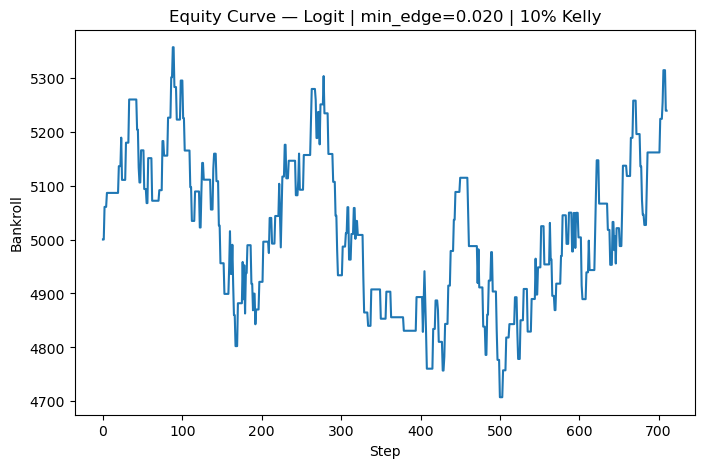

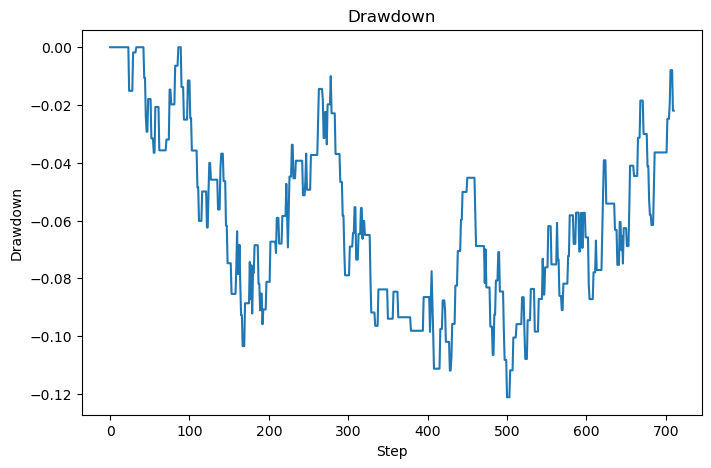

Summary: {'n_bets': 204, 'roi': 0.04776632423726132, 'profit': 238.83162118630662, 'ending_bankroll': 5238.831621186307, 'max_drawdown': -0.12113836793097421, 'hit_rate': 0.5098039215686274, 'avg_edge': 0.05792650648753875, 'avg_stake': 59.3960596605365}
Bets placed: 204


,gamePk,gameDate,side,p,dec,edge,stake,pnl,bankroll
0,2023020144,2023-11-01 00:00:00,home,0.538951,2.080000,0.058182,56.027019,60.509180,5060.509180
1,2023020152,2023-11-02 00:00:00,away,0.461049,2.280000,0.022452,20.238641,25.905461,5086.414642
2,2023020186,2023-11-07 00:00:00,home,0.609708,1.800000,0.054152,61.974330,49.579464,5135.994106
3,2023020191,2023-11-08 00:00:00,away,0.647215,1.704225,0.060438,75.119351,52.900951,5188.895057
4,2023020192,2023-11-08 00:00:00,home,0.630855,1.769231,0.065638,78.335514,-78.335514,5110.559543
5,2023020202,2023-11-09 00:00:00,away,0.567464,2.000000,0.067464,68.955440,68.955440,5179.514983
6,2023020218,2023-11-11 00:00:00,away,0.513169,2.250000,0.068725,64.072827,80.091034,5259.606017
7,2023020249,2023-11-16 00:00:00,away,0.527822,2.120000,0.056124,55.875075,-55.875075,5203.730942
8,2023020247,2023-11-16 00:00:00,away,0.514320,2.280000,0.075724,70.189494,-70.189494,5133.541448
9,2023020257,2023-11-18 00:00:00,away,0.588758,1.769231,0.023541,27.794631,-27.794631,5105.746817


In [404]:
import matplotlib.pyplot as plt

eq = np.array(equity, dtype=float)
peak = np.maximum.accumulate(eq)
dd = (eq - peak) / peak

plt.figure(figsize=(8,5))
plt.plot(eq)
plt.title(f"Equity Curve — {MODEL_NAME} | min_edge={MIN_EDGE:.3f} | {int(KELLY_SCALE*100)}% Kelly")
plt.xlabel("Step")
plt.ylabel("Bankroll")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(dd)
plt.title("Drawdown")
plt.xlabel("Step")
plt.ylabel("Drawdown")
plt.show()

print("Summary:", summary)
print("Bets placed:", len(df_bets))
display(df_bets.head(10))


In [405]:
print("Games in backtest frame:", len(df_bt))
print("Bets placed:", len(df_bets))
print("Avg stake:", df_bets["stake"].mean() if len(df_bets) else None)
print("Median stake:", df_bets["stake"].median() if len(df_bets) else None)
print("Max stake:", df_bets["stake"].max() if len(df_bets) else None)
print("Avg edge:", df_bets["edge"].mean() if len(df_bets) else None)
print("Hit rate:", (df_bets["pnl"] > 0).mean() if len(df_bets) else None)


Games in backtest frame: 710
Bets placed: 204
Avg stake: 59.3960596605365
Median stake: 61.83981590794815
Max stake: 97.18310635319511
Avg edge: 0.05792650648753875
Hit rate: 0.5098039215686274


In [406]:
# Reliability diagram (10 bins)
tmp = df_bt.copy()
tmp["y"] = tmp["homeWin"].astype(int)

tmp["bin"] = pd.qcut(tmp["p_home"], 10, duplicates="drop")
cal = tmp.groupby("bin").agg(
    n=("y","size"),
    p_hat=("p_home","mean"),
    win_rate=("y","mean"),
).reset_index(drop=True)

cal["gap"] = cal["win_rate"] - cal["p_hat"]
cal


/var/folders/cf/4zyl4dsd16n9yhd_dkhk66gc0000gn/T/ipykernel_46433/25428912.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = tmp.groupby("bin").agg(


,n,p_hat,win_rate,gap
0,71,0.353766,0.535211,0.181446
1,71,0.413744,0.422535,0.008792
2,71,0.447629,0.492958,0.045329
3,71,0.479728,0.521127,0.041399
4,71,0.507830,0.591549,0.083720
5,76,0.529730,0.513158,-0.016572
6,66,0.546268,0.484848,-0.061419
7,71,0.572954,0.492958,-0.079996
8,71,0.621265,0.492958,-0.128307
9,71,0.690880,0.535211,-0.155668


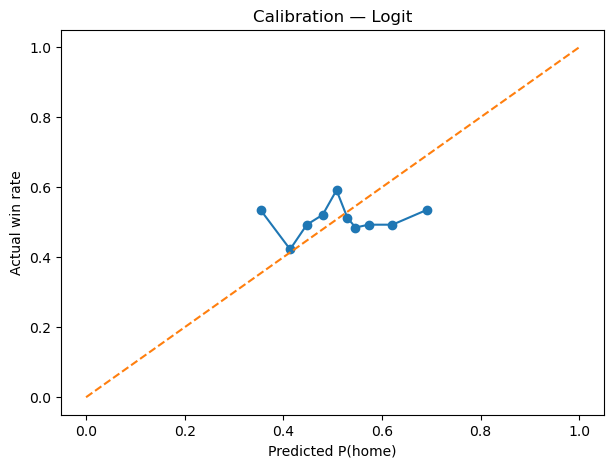

In [407]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(cal["p_hat"], cal["win_rate"], marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted P(home)")
plt.ylabel("Actual win rate")
plt.title(f"Calibration — {MODEL_NAME}")
plt.show()


In [408]:
bets = df_bets.copy()
bets["edge_bin"] = pd.cut(bets["edge"], bins=[0, .01, .02, .03, .05, .08, .12, 1.0], include_lowest=True)

roi_by = bets.groupby("edge_bin").agg(
    n=("pnl","size"),
    profit=("pnl","sum"),
    stake=("stake","sum"),
).reset_index()

roi_by["roi"] = roi_by["profit"] / roi_by["stake"]
roi_by


/var/folders/cf/4zyl4dsd16n9yhd_dkhk66gc0000gn/T/ipykernel_46433/1882957266.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  roi_by = bets.groupby("edge_bin").agg(


,edge_bin,n,profit,stake,roi
0,"(-0.001, 0.01]",0,0.000000,0.000000,NaN
1,"(0.01, 0.02]",0,0.000000,0.000000,NaN
2,"(0.02, 0.03]",30,-14.996147,755.318481,-0.019854
3,"(0.03, 0.05]",0,0.000000,0.000000,NaN
4,"(0.05, 0.08]",174,253.827768,11361.477689,0.022341
5,"(0.08, 0.12]",0,0.000000,0.000000,NaN
6,"(0.12, 1.0]",0,0.000000,0.000000,NaN


In [409]:
# =========================
# SAVE PRODUCTION MODEL
# =========================

import joblib
from datetime import datetime

# ---- SELECT MODEL TO DEPLOY ----
MODEL_NAME = "Logit"        # change if needed
MODEL_OBJ  = logit          # e.g. logit, rf, xgb_model, etc.

# ---- METADATA (optional but useful) ----
meta = {
    "model_name": MODEL_NAME,
    "trained_on": datetime.utcnow().isoformat() + "Z",
    "features": list(X_train.columns),
    "n_features": X_train.shape[1],
    "train_rows": len(X_train),
    "test_rows": len(X_test),
    "notes": "Opening-line NHL model | 1/10 Kelly | max stake 2%"
}

# ---- SAVE ----
OUT_PATH = "model_logit.joblib"

joblib.dump(
    {
        "model": MODEL_OBJ,
        "meta": meta
    },
    OUT_PATH,
    compress=3
)

print(f"✅ Saved production model to {OUT_PATH}")
print("Features:", len(meta["features"]))


✅ Saved production model to model_logit.joblib
Features: 90
